In [2]:
import numpy as np
import gym
from collections import namedtuple
env = gym.make("CartPole-v1")
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from copy import deepcopy
from gym import wrappers
from time import time

/Users/ndeutsch/code/reinforcement-learning-exercises/venv_rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Getting the interactions with the environment right before the model

In [3]:
# Random movement
observation = env.reset()
for _ in range(100):
  env.render()
  action = env.action_space.sample() # your agent here (this takes random actions)
  observation, reward, done, info = env.step(action)

  if done:
    observation = env.reset()
env.close()

In [4]:
# looking at what we can interact with
print(env.action_space)
for i in range(5):
    print(env.action_space.sample())

Discrete(2)
1
0
1
0
1


In [13]:
# Understanding the action space: action 1
observation = env.reset()
for _ in range(100):
  env.render()
  action = 1
  observation, reward, done, info = env.step(action)
  #if done:
    #observation = env.reset()
env.close()

In [14]:
# Understanding the action space: action 2
observation = env.reset()
for _ in range(100):
  env.render()
  action = 0
  observation, reward, done, info = env.step(action)
  #if done:
    #observation = env.reset()
env.close()

In [15]:
# What does the output look like?
env.reset()
data = env.step(0)
print(data)

(array([ 0.016848  , -0.1580901 ,  0.00284445,  0.24564078]), 1.0, False, {})


In [16]:
# Creating a data structure for the state
observation_fields = ["position","velocity","angle","angular_velocity"]
cartpole_space = namedtuple("cartpole_state",observation_fields)
# Did not end up using it as it does not interact nicely with 
# numpy arrays. If actually needed some kind of pandas dataframe 
# is most likely better suited

In [18]:
# stupid alg as a baseline:
# if the rod is angled left, move left and vice versa
v = 0.1
Reward = 0
observation = env.reset()
for _ in range(1000):
    env.render()
    action = 1 if v > 0 else 0
    observation, reward, done, info = env.step(action)
    v = observation[-2]
    Reward += reward
    if done:
        break
env.close()
# Total episode reward
print(Reward)
# Just checking if moving into a terminal state yields a reward - it does
print(reward)

# Order 40-50 reward is typically achieved with this basic approach

49.0
1.0


In [21]:
# In preparation for having a proper model
# let us define a random agent
# just useful to check that functions are outputting in the
# right format
def stupid_model(state):
    p = (np.random.rand(state.shape[0],2)) 
    return p

In [26]:
# Defining a batch of states
states = np.random.rand(12,4)
stupid_model(states)

array([[0.96087131, 0.37424819],
       [0.99674897, 0.84090107],
       [0.0097913 , 0.67508601],
       [0.28496538, 0.04015029],
       [0.26777551, 0.29658595],
       [0.06055287, 0.16106181],
       [0.7970552 , 0.17381991],
       [0.29185388, 0.7562931 ],
       [0.61567824, 0.3729022 ],
       [0.58991585, 0.54906541],
       [0.39329651, 0.69207946],
       [0.56151422, 0.83284607]])

In [27]:
# Numpy-based experience replay buffer
class ExperienceBuffer:
    def __init__(self,capacity=10):
        self.capacity = capacity
        self.initial_states = np.zeros((capacity,4))
        self.actions = np.zeros(capacity,dtype=np.int)
        self.rewards = np.zeros(capacity)
        self.final_states = np.zeros((capacity,4))
        self.terminal = np.zeros(capacity,dtype=np.int)
        self.head = 0
        self.full = False
        
    def collect(self,s,a,r,st,status):
        self.initial_states[self.head] = s
        self.actions[self.head] = a
        self.rewards[self.head] = r
        self.final_states[self.head] = st
        self.terminal[self.head] = status
        self.head = (self.head + 1) % self.capacity
        if not self.full:
            if self.head == self.capacity-1:
                self.full = True
        
    def batch(self,batch_size):
        if self.full:
            indices = np.random.choice(self.capacity,batch_size,replace=True)
        else:
            indices = np.random.choice(self.head+1,batch_size,replace=True)
            
        return self.initial_states[indices], self.actions[indices], self.rewards[indices],self.final_states[indices],self.terminal[indices]
    

In [29]:
buffer = ExperienceBuffer(capacity=10)

In [30]:
# preparing the training loop (DEBUG)

# Get a state from the initialization of the environment, batch-format it
state = np.expand_dims(env.reset(),axis=0)

# The model outputs the Q-values of action 0 and 1, choose the greedy action
action = np.argmax(stupid_model(state))

# Take a step and collect data
observation, reward, done, info = env.step(action)

new_state = np.expand_dims(observation,axis=0)
buffer.collect(state,action,reward,new_state,done) # S.A.R.S.DONE ^^

In [31]:
# training loop
buffer = ExperienceBuffer(capacity=100)
state = np.expand_dims(env.reset(),axis=0)
for _ in range(100):
    action = np.argmax(stupid_model(state))
    observation, reward, done, info = env.step(action)
    new_state = np.expand_dims(observation,axis=0)
    buffer.collect(state,action,reward,new_state,done)

    if done:
        state=np.expand_dims(env.reset(),axis=0)
    else:
        state=new_state
env.close()

In [34]:
# Get a batch of data from the buffer and return the relevant info for training

def process_memory(model,discount_rate,initial_states,actions,rewards,final_states,terminal):
    # This is supposed to take in the frozen model to predict the curent target
    state_values = np.max(model(final_states),axis=-1)
    # Q_value(state,action) = Reward(state,action) + gamma * max(Q_value(new_state,:possible_actions:))
    targets = rewards + discount_rate*state_values*(1-terminal)
    # just for debugging
    print(terminal)
    return targets,actions,initial_states

In [38]:
print(process_memory(stupid_model,0.9,*buffer.batch(100)))
targets,actions,initial_states = process_memory(stupid_model,0.9,*buffer.batch(10))
# Note that the target is exactly 1 for next-to-terminal states while 1+Q for the rest

[0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
(array([1.30263588, 1.17623111, 1.37854306, 1.46575096, 1.83658349,
       1.11756616, 1.        , 1.        , 1.55267605, 1.3221905 ,
       1.3763694 , 1.49158356, 1.3424981 , 1.        , 1.65285058,
       1.56028362, 1.73348606, 1.56951784, 1.33586989, 1.57246024,
       1.38157436, 1.86193137, 1.47374071, 1.81776836, 1.65789553,
       1.74990699, 1.81949719, 1.86035395, 1.8266968 , 1.41964905,
       1.7431051 , 1.7030732 , 1.76361881, 1.7829401 , 1.86553002,
       1.79153358, 1.69862047, 1.        , 1.67795141, 1.6710194 ,
       1.68824563, 1.59909808, 1.59142722, 1.69471824, 1.78583074,
       1.443022  , 1.15197494, 1.5196541 , 1.50397131, 1.61386717,
       1.4012002 , 1.78826764, 1.48688441, 1.70179532, 1.75914264,
       1.54426103, 1.7039552 , 1.65447453, 1.18377024, 1.5

In [28]:
# preparing for learning: getting the Q of the state
predicted_values = stupid_model(initial_states)
# getting a batch of actions
predicted_chosen_values = predicted_values[np.arange(10),actions]
# consistency check
predicted_values[0],actions[0],predicted_chosen_values[0]

(array([0.2767306 , 0.89816115]), 1, 0.8981611544737925)

In [39]:
# Just to get the structure and input dimensions rights: fake training step
def train_on_batch(model_to_train,target_model,batch_size,experience_buffer):
    # Collect experience and prepare predictions and targets
    experience = experience_buffer.batch(batch_size)
    targets,actions,initial_states = process_memory(target_model,0.9,*experience)
    # start tracking gradients if needed, empty gradient buffers
    predicted_values = model_to_train(initial_states)[np.arange(batch_size),actions]
    loss = (predicted_values-targets)**2
    # apply gradient descent
    return loss

In [40]:
train_on_batch(stupid_model,stupid_model,10,buffer)

[0 0 0 0 0 0 0 0 0 0]


array([1.67552306, 0.07292392, 1.17951644, 1.58473372, 1.51846715,
       0.15909019, 1.90647356, 1.68883088, 1.29680662, 0.99805607])

# Redoing it with NNs

In [43]:
class QNet(nn.Module):

    def __init__(self):
        super(QNet, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)
#       self.bn1 = nn.BatchNorm1d(4)
#       Batch norm is actually a bad idea: the states are correlated and trying to force them to be normal
#       probably hurts (as seen when testing)

    def forward(self, x):
#        x = self.bn1(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# The target network is the same but non-trainable
class QNetStatic(QNet):

    def __init__(self):
        super(QNetStatic, self).__init__()       
        for param in self.parameters():
            param.requires_grad=False

In [45]:
# testing instantiation and synchronization
training_qnet = QNet()
target_qnet = QNetStatic()
target_qnet.load_state_dict(training_qnet.state_dict())

# Checking that the output is the same but that no gradient function is generated in the target net
x=torch.tensor(np.random.uniform(0,1,(10,4)).astype(np.float32),requires_grad=False)
print(training_qnet(x))
print(target_qnet(x))

tensor([[0.1788, 0.0000],
        [0.1781, 0.0000],
        [0.1862, 0.0000],
        [0.1455, 0.0000],
        [0.1913, 0.0000],
        [0.1739, 0.0000],
        [0.1555, 0.0000],
        [0.1903, 0.0000],
        [0.1522, 0.0000],
        [0.1957, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.1788, 0.0000],
        [0.1781, 0.0000],
        [0.1862, 0.0000],
        [0.1455, 0.0000],
        [0.1913, 0.0000],
        [0.1739, 0.0000],
        [0.1555, 0.0000],
        [0.1903, 0.0000],
        [0.1522, 0.0000],
        [0.1957, 0.0000]])


In [46]:
# Torch version of the experience buffer
class ExperienceBuffer:
    def __init__(self,capacity=10):
        self.capacity = capacity
        self.initial_states = torch.zeros((capacity,4),requires_grad=False)
        self.actions = torch.zeros(capacity,dtype=np.int,requires_grad=False)
        self.rewards = torch.zeros(capacity,requires_grad=False)
        self.final_states = torch.zeros((capacity,4),requires_grad=False)
        self.terminal = torch.zeros(capacity,dtype=np.int,requires_grad=False)
        self.head = 0
        self.full = False
        
    def collect(self,s,a,r,st,status):
        self.initial_states[self.head] = s
        self.actions[self.head] = a
        self.rewards[self.head] = r
        self.final_states[self.head] = st
        self.terminal[self.head] = status
        self.head = (self.head + 1) % self.capacity
        if not self.full:
            if self.head == self.capacity-1:
                self.full = True
        
    def batch(self,batch_size):
        if self.full:
            indices = torch.randint(0, self.capacity, (batch_size,))
        else:
            indices = torch.randint(0, self.head+1, (batch_size,))
        return self.initial_states[indices], self.actions[indices], self.rewards[indices],self.final_states[indices],self.terminal[indices]
    

In [47]:
# training loop
# Checking the buffer and np-torch conversions

buffer = ExperienceBuffer(capacity=1000)
state = np.expand_dims(env.reset(),axis=0)
for _ in range(100):
    action = np.argmax(stupid_model(state))
    observation, reward, done, info = env.step(action)
    new_state = np.expand_dims(observation,axis=0)
    buffer.collect(torch.tensor(state,dtype=torch.float32),torch.tensor(action,dtype=torch.int32),reward,torch.tensor(new_state,dtype=torch.float32),done)

    if done:
        state=np.expand_dims(env.reset(),axis=0)
    else:
        state=new_state
env.close()
buffer.batch(2)

(tensor([[-0.0068, -0.6052,  0.0335,  0.8470],
         [-0.0880, -0.4182,  0.1542,  0.7397]]),
 tensor([1, 1]),
 tensor([1., 1.]),
 tensor([[-0.0189, -0.4106,  0.0504,  0.5650],
         [-0.0963, -0.2255,  0.1689,  0.4992]]),
 tensor([0, 0]))

In [48]:
def process_memory(model,discount_rate,initial_states,actions,rewards,final_states,terminal):
    predictions = model(final_states)
    state_values = torch.max(predictions,axis=-1)
    targets = rewards + discount_rate*(1.-terminal)*state_values.values
    return targets,actions,initial_states

In [49]:
target_qnet = QNetStatic()

In [52]:
# checking input-output for process_memory. Note again that no grad_fn is generated
targets,actions,initial_states=process_memory(target_qnet,0.9,*buffer.batch(10))
print(targets,actions,initial_states)
print(initial_states.shape)

tensor([1.1073, 1.0740, 1.0687, 1.0949, 1.0740, 1.0786, 1.0743, 1.0743, 1.0740,
        1.0741]) tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1]) tensor([[ 3.4116e-02, -7.8092e-01,  2.1437e-02,  1.1632e+00],
        [ 5.6829e-03, -2.1444e-01,  1.7549e-02,  2.4913e-01],
        [ 1.6968e-02, -5.5635e-03,  6.0202e-03,  1.0557e-01],
        [ 4.5331e-03,  3.8264e-01,  3.7582e-02, -4.3520e-01],
        [ 1.8158e-02, -2.1431e-01,  1.8272e-03,  2.4642e-01],
        [ 7.7056e-04,  1.8812e-01,  4.0694e-02, -1.5563e-01],
        [ 3.5315e-02, -2.1475e-01, -1.8136e-02,  2.5607e-01],
        [ 2.1473e-02, -1.9552e-01, -8.6468e-03,  2.8431e-01],
        [ 5.6829e-03, -2.1444e-01,  1.7549e-02,  2.4913e-01],
        [-6.8019e-03, -6.0523e-01,  3.3478e-02,  8.4699e-01]])
torch.Size([10, 4])


In [54]:
# Proper training function
def train_nns_on_batch(model_to_train,target_model,batch_size,experience_buffer,discount_rate=0.99,learning_rate=0.01,optimizer=None):
    # Collect experience and prepare predictions and targets
    experience = experience_buffer.batch(batch_size)
    targets,actions,initial_states = process_memory(target_model,discount_rate,*experience)
    
    # start tracking gradients if needed, empty gradient buffers
    model_to_train.train()
    model_to_train.zero_grad()
    predicted_values = model_to_train(initial_states)[torch.arange(batch_size),actions]
    loss = torch.mean((predicted_values-targets)**2)
    # Compute gradients
    loss.backward()
    # apply gradient descent (basic sgd) - turns out to work quite well 
    if optimizer is None:
        for param in model_to_train.parameters():
            old_data=param.data.clone()
            param.data.sub_(param.grad.data * learning_rate)
    else:
        optimizer.step()
    
    # We're returning a lot of data for debugging
    return loss,experience,targets,actions,initial_states

In [55]:
# checking the training function
buffer = ExperienceBuffer(capacity=10)
state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
training_qnet = QNet()
target_qnet = QNetStatic()
target_qnet.load_state_dict(training_qnet.state_dict())
target_qnet.eval()
# content of the loop

training_qnet.eval()
action=(torch.argmax(training_qnet(state.reshape(1,4))))
observation, reward, done, info = env.step(action.numpy())
new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
print(state,action,reward,new_state,done)
buffer.collect(state,action,torch.tensor(reward,dtype=torch.float32,requires_grad=False),new_state,done)
if done:
    torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
else:
    state=new_state

print("\nBuffer full: "+str(buffer.full))

loss,experience,targets,actions,initial_states=train_nns_on_batch(training_qnet,target_qnet,5,buffer)
loss

tensor([ 0.0326,  0.0205, -0.0029, -0.0172]) tensor(0) 1.0 tensor([ 0.0331, -0.1745, -0.0032,  0.2746]) False

Buffer full: False


tensor(0.3979, grad_fn=<MeanBackward0>)

saved state at step 0 for avg reward 0.90
saved state at step 2 for avg reward 1.81
saved state at step 3 for avg reward 2.83
saved state at step 4 for avg reward 3.45
saved state at step 5 for avg reward 4.40
saved state at step 6 for avg reward 4.96
saved state at step 7 for avg reward 5.47
saved state at step 9 for avg reward 6.02
saved state at step 10 for avg reward 7.02
saved state at step 12 for avg reward 7.92
saved state at step 14 for avg reward 9.42
saved state at step 17 for avg reward 10.48
saved state at step 20 for avg reward 12.83
saved state at step 368 for avg reward 14.30
saved state at step 400 for avg reward 15.80
saved state at step 503 for avg reward 18.03
saved state at step 557 for avg reward 20.36
saved state at step 593 for avg reward 25.87
saved state at step 602 for avg reward 33.08
saved state at step 621 for avg reward 37.23
saved state at step 649 for avg reward 42.88
saved state at step 803 for avg reward 49.35
saved state at step 819 for avg reward 55.

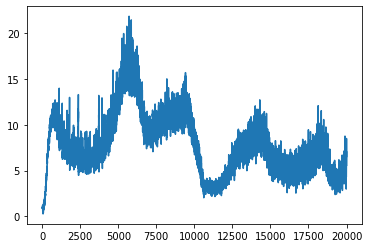

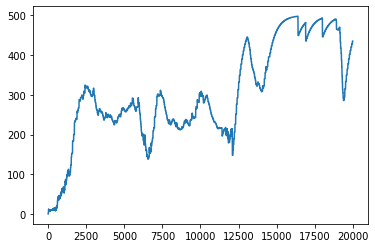

In [56]:
# Running the training function

# Initialization of the main objects
buffer = ExperienceBuffer(capacity=100000)
training_qnet = QNet()
target_qnet = QNetStatic()
target_qnet.load_state_dict(training_qnet.state_dict())
# Double ensure that no training is even attempted on the target
target_qnet.eval()

# My short experience: tuning the lr of basic, hand-applied SGD, is easier than advanced stuff - for this task
optimizer = None #torch.optim.RMSprop(training_qnet.parameters(),lr=0.0001,eps=0.1,alpha=0.9)

# Hyper-parameters: target refresh rate and greediness
C = 20
epsilon=0.1


# Pretty progress bar
progress_bar = tqdm(range(20000))
###############
# Telemetry

# For plotting
history = {'loss':[],'avg_reward':[]}

# episode length
current_run = 0
# Top episode length (to schedule saves)
longest_run = 0

# running avg length with an update weigh
avg_run = 0
weight = 0.1

# Top averaged length (to smooth out fluctuations)
best_avg = 0

# NN states to replay performance along the training
saved_states = [training_qnet.state_dict()]

state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)

for j in progress_bar:
    # Fill up 10 epsilon-greedy runs following the Q-net
    # We are not training now
    training_qnet.eval()
    for i in range(10):
        # Epsilon-greedy run
        if np.random.rand()<epsilon:
            action = torch.tensor(env.action_space.sample(),dtype=torch.int32)
        else:
            action=(torch.argmax(training_qnet(state.reshape(1,4))))
        # Take the action, observe the result and memorize it all
        observation, reward, done, info = env.step(action.numpy())
        new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
        buffer.collect(state,action,torch.tensor(reward,dtype=torch.float32,requires_grad=False),new_state,done)
        #print(state,action,reward,new_state,done)
        
        if done:
            # At episode end, reset, update metrics
            torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
            longest_run = max(longest_run,current_run)
            avg_run = current_run*weight + avg_run*(1-weight)

            # if we improved 10% over the last best perf, update best perf and save
            if avg_run > 1.1*best_avg:
                best_avg = avg_run
                saved_states.append(deepcopy(training_qnet.state_dict()))
                print("saved state at step {j} for avg reward {avg_run:.2f}".format(j=j,avg_run=avg_run))
            # Reset epsiode lenght counter
            current_run=0
        else:
            state=new_state
            current_run+=1
        
    # Take one gradient step on a batch
    loss,_,_,_,_ = train_nns_on_batch(training_qnet,target_qnet,10000,buffer,discount_rate=0.999,learning_rate=0.01,optimizer=optimizer)
    
    # Log plot metrics
    history['loss'].append(loss)
    history['avg_reward'].append(avg_run)
    
    # update progress bar with metrics for impatient observers
    progress_bar.set_description("Loss = {0:.2f} | MAVG {1} | AVG {2}".format(loss,int(best_avg), int(avg_run)))

    # Every C steps, update the target
    if j%C==0:
        target_qnet.load_state_dict(training_qnet.state_dict())        

env.reset()
env.close()

plt.plot(history['loss'])
plt.show()
plt.plot(history['avg_reward'])
plt.show()


In [68]:
#training_qnet.load_state_dict(saved_states[-1])
training_qnet.eval()
state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
for i in range(500):
    action=(torch.argmax(training_qnet(state.reshape(1,4))))

    observation, reward, done, info = env.step(action.numpy())
    new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
    if done:
        torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
        print(i)
    else:
        state=new_state
    env.render()
env.close()

499


In [25]:
# Output a nice video
video_env = wrappers.Monitor(env, './videos/' + str(time()) + '/')

training_qnet.load_state_dict(saved_states[-1])
training_qnet.eval()

state =torch.tensor( (video_env.reset().astype(np.float32)),requires_grad=False)
for i in range(500):

        action=(torch.argmax(training_qnet(state.reshape(1,4))))

        observation, reward, done, info = video_env.step(action.numpy())
        new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
        if done:
            print(i)
            break
            #torch.tensor( (video_env.reset().astype(np.float32)),requires_grad=False)
        else:
            state=new_state
video_env.close()

499


In [132]:
# save the model state to rebuild later
torch.save(saved_states[-1],"./model_state_1")

In [12]:
# load a saved state
training_qnet.load_state_dict(torch.load("./model_state_1"))

<All keys matched successfully>